In [251]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
import urllib.request
import pandas as pd

def coloravg(c1,c2):
    rgb0 = mcolors.colorConverter.to_rgb(c1)
    rgb1 = mcolors.colorConverter.to_rgb(c2)
    rgb = [np.sqrt((rgb0[i]**2 + rgb1[i]**2)/2) for i in range(3)]
    return rgb

LEVELS = {
    "0.0": {"name":"V-B/0", "colors":["#db67cc","#db67cc"]},
    "0.5": {"name":"V-0/1", "colors":["#db67cc","#FFFB4F"]},
    "1.5": {"name":"V-1/2", "colors":["#FFFB4F","#FFFB4F"]},
    "2.5": {"name":"V-2/3", "colors":["#FFFB4F","#64A25A"]},
    "3.5": {"name":"V-3/4", "colors":["#64A25A","#64A25A"]},
    "4.5": {"name":"V-4/5", "colors":["#64A25A","#FFA135"]},
    "5.5": {"name":"V-5/6", "colors":["#FFA135","#FFA135"]},
    "6.5": {"name":"V-6/7", "colors":["#FFA135","#008BEE"]},
    "7.5": {"name":"V-7/8", "colors":["#008BEE","#008BEE"]},
    "8.5": {"name":"V-8/9", "colors":["#008BEE","#dddddd"]},
    "9.5": {"name":"V-9+", "colors":["#dddddd","#dddddd"]},
}

def dfdates2datetimes(dates):
    return [datetime.strptime(str(d[0]).replace('T00:00:00.000000000',''), "%Y-%m-%d") for d in dates]
    


In [252]:
def plot_cum_frac(df, attempt=0):
    levels = sorted(df[df['attempt']==attempt]['level'].unique())
    dates = sorted(df[df['attempt']==attempt]['date'].unique())
    totals_by_level = df[df['attempt']==attempt].pivot_table(index='date', columns='level',values='count',aggfunc='sum',fill_value=0).to_numpy()
    totals_by_date = df[df['attempt']==attempt].groupby('date').sum()['count'].to_numpy()

    frac_by_level = (totals_by_level.T/totals_by_date)
    cum_by_level = np.cumsum(frac_by_level, axis=0)

    fig, ax = plt.subplots(1,1,figsize=(14,6))

    for i, l in enumerate(levels):
        #ax.plot(dates, frac_by_level[i,:], color=coloravg(*LEVELS[str(L)]["colors"]))


        if i==0:
            ax.fill_between(dates,
                            cum_by_level[i,:],
                            np.zeros_like(cum_by_level[i,:]),
                            color=coloravg(*LEVELS[str(l)]["colors"]),
                            label=LEVELS[str(l)]['name'],
                             )
        else:
            ax.fill_between(dates,
                            cum_by_level[i,:],
                            cum_by_level[i-1,:], 
                            color=coloravg(*LEVELS[str(l)]["colors"]),
                            label=LEVELS[str(l)]['name'],
                           )
    ax.set_xlim([min(dates), max(dates)])
    ax.set_ylim([0,1])
    if attempt==0:
        label="successful"
    else:
        label="attempted"
    ax.set_title(f"Fraction {label} climbs by level")

    fig.show()
    

    
def climbing_score(df):
    df['score'] = df.apply(lambda row: -1*row['level']*row['count'] if row['attempt']==1 else 2*row['level']**2*row['count'] + 4.0*row['flash']**2, axis=1)
    dates = df['date'].unique()
    scores = df.groupby('date').sum()['score']

    fig, ax = plt.subplots(1,1,figsize=(14,6))
    ax.set_ylabel("Score")
    ax.plot(dates, scores, 'ko-')


    ax.set_xlabel("Date")
    ax.set_title("Climbing score, S")
    ax.text(0.95,0.95,"$S=4\sum g^2_\mathrm{flash} + 2\sum g^2_\mathrm{complete} +  \sum g_\mathrm{attempt} $", va='top', ha='right', transform=ax.transAxes, size=20)





/home/kmills/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


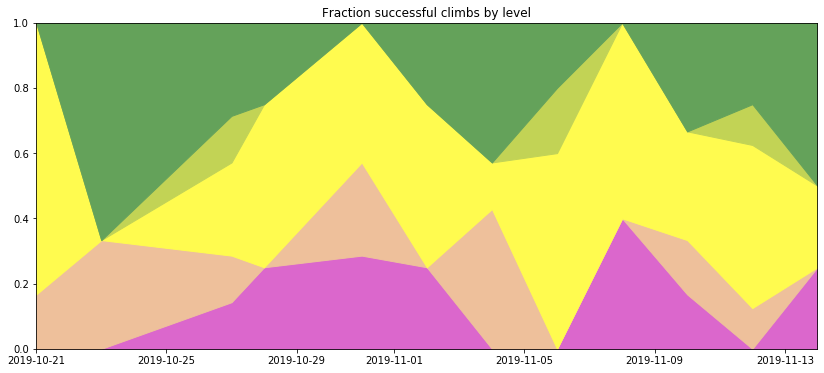

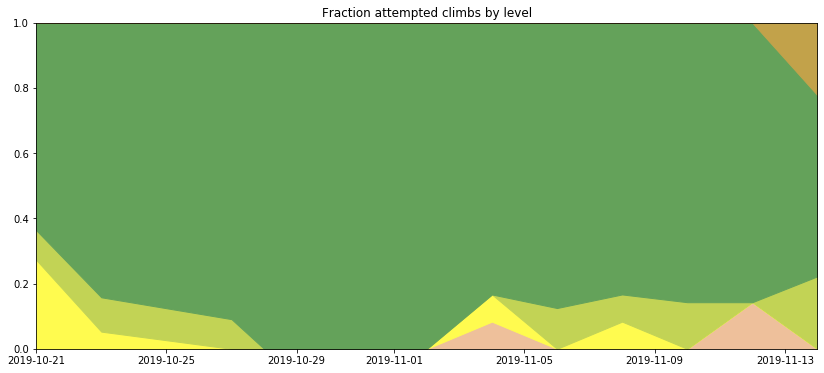

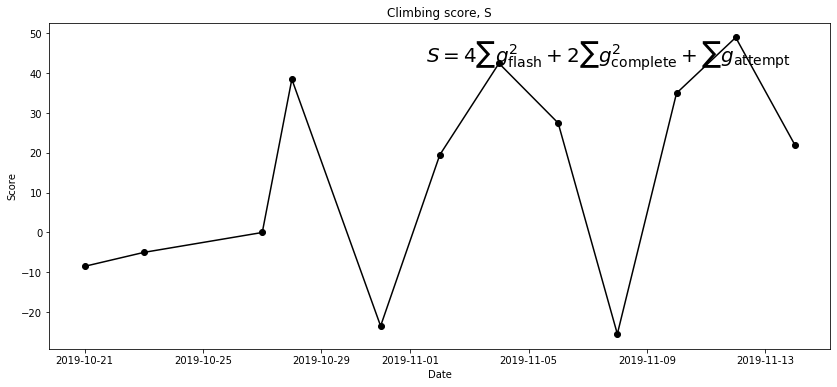

In [253]:
urllib.request.urlretrieve("http://kylemills.ca/climbing/dump.php?u=kmills&report_id=1&y=6", '/tmp/out.txt')
df = pd.read_csv("/tmp/out.txt")
df['date']= pd.to_datetime(df['date']) 
    
plot_cum_frac(df, attempt=0)
plot_cum_frac(df, attempt=1)
climbing_score(df)


/home/kmills/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


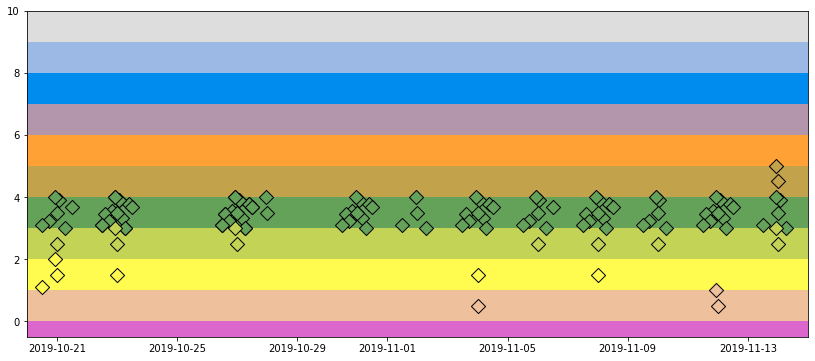

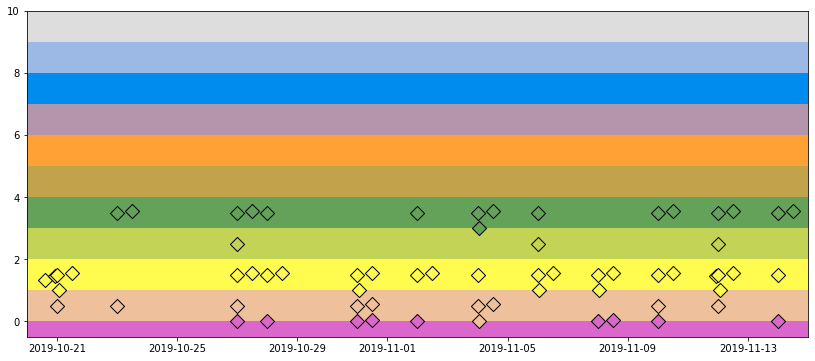

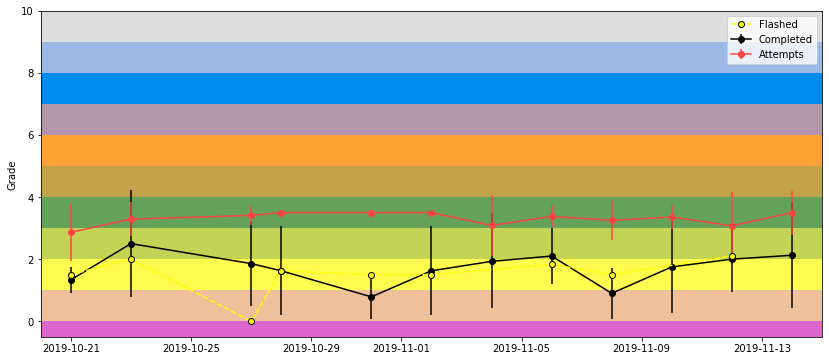

In [254]:
def vector_level_to_color(levels):
    return [coloravg(*LEVELS[str(l)]["colors"]) for l in levels]
    

def climbing_trends(df):
    dates = dfdates2datetimes(df[df['attempt']==0].groupby(['date'])['date'].unique())

    S_mean = df[df['attempt']==0].groupby(['date']).mean()['level']
    S_std = df[df['attempt']==0].groupby(['date']).std()['level']

    A_mean = df[df['attempt']==1].groupby(['date']).mean()['level']
    A_std = df[df['attempt']==1].groupby(['date']).std()['level']


    fig, ax = plt.subplots(1,1,figsize=(14,6))
    ax.errorbar(dates, S_mean, yerr=S_std, color='k', marker='o', label='Completed')
    ax.errorbar(dates, A_mean, yerr=A_std, color='#FF4444', marker='o', alpha=1.0, label='Attempts')


    F = df[df['flash']==1].groupby(['date']).sum()['level'] / df[df['flash']==1].groupby(['date']).sum()['flash']
    flashdates = F.keys()
    flashlevels = np.array(F)


    ax.plot(flashdates, flashlevels, 'o--', color='yellow', markeredgecolor='k', zorder=5, label='Flashed')


    ls_ = reversed(list(LEVELS.keys()))
    is_ = reversed(list(range(len(list(LEVELS.keys())))))

    for l, i in zip(ls_, is_):
        if i == 0:
            lower = float(l)-0.5
            upper = 0
        else:
            lower = float(l)-0.5
            upper = float(l)+0.5
        ax.axhspan(lower, upper, color=coloravg(*LEVELS[str(l)]["colors"]))
        
    ax.set_xlim([dates[0] -timedelta(days=1), dates[-1] + timedelta(days=1)])

    ax.set_ylim([-0.5,10])
    ax.set_ylabel("Grade")
    ax.legend()
    fig.show()    

def scatterplotclimbs(df, attempt=0):
    
    
    fig, ax = plt.subplots(1,1,figsize=(14,6))
    
    dat = df[df['attempt']==attempt]
    dates = dat['date']
    
    
    mean = df[df['attempt']==attempt].groupby(['date']).mean()['level']
    std = df[df['attempt']==attempt].groupby(['date']).std()['level']
    udates = dat['date'].unique()
    
    bar_background=True
    if bar_background:
        ls_ = reversed(list(LEVELS.keys()))
        is_ = reversed(list(range(len(list(LEVELS.keys())))))

        for l, i in zip(ls_, is_):
            if i == 0:
                lower = float(l)-0.5
                upper = 0
            else:
                lower = float(l)-0.5
                upper = float(l)+0.5

            ax.axhspan(lower, upper, color=coloravg(*LEVELS[str(l)]["colors"]))


    
    numpoints = dat['level'].shape[0]
    
    rs = np.tile(np.linspace(0,1.0,num=10), numpoints//10+1)-0.5
    rs=rs[0:numpoints]
    #r = np.random.rand(numpoints)-0.5
    r=rs
    
    uniquedates = dates.unique()
    uniquelevels = dat['level'].unique()
    
    yoffsets = [0,]
    rs = np.linspace(-0.5,0.5,num=10)
    np.random.shuffle(rs)
    for i in rs:
        yoffsets.append(i)
    
    
    toffsets = [timedelta(hours=0)]
    rs = np.linspace(-12,12,num=10)
    np.random.shuffle(rs)
    for i in rs:
        toffsets.append(timedelta(hours=i))
    
    for date in uniquedates:
        for level in uniquelevels:
            i = -1
            result = df[(df['attempt']==attempt) &
                            (df['date']==date) & 
                            (df['level']==level)]           
            for idx, point in result.iterrows():
                i += 1
                ax.scatter(x=point['date']+toffsets[i%len(toffsets)], y=point['level']+yoffsets[i%len(yoffsets)], marker='D',s=100,edgecolor='k',
                           zorder=1000-i, color=vector_level_to_color([point['level']]))
    ax.set_ylim([-0.5, 10])
    
    ax.set_xlim([uniquedates.min()-np.timedelta64(1, 'D'),uniquedates.max()+np.timedelta64(1, 'D')])

urllib.request.urlretrieve("http://kylemills.ca/climbing/dump.php?u=kmills", '/tmp/out.txt')
df = pd.read_csv("/tmp/out.txt")
df['date']= pd.to_datetime(df['date']) 

scatterplotclimbs(df, attempt=1)
scatterplotclimbs(df, attempt=0)
climbing_trends(df)


In [156]:
uniquedates = df['date'].unique()
uniquelevels = df['level'].unique()
for date in uniquedates:
    for level in uniquelevels:
        for p in df[(df['date']==date) & (df['level']==level)].iterrows():
            print(p)
    

(0, date          2019-10-21 00:00:00
level                         1.5
attempt                         1
flash                           0
Unnamed: 4                    NaN
Name: 0, dtype: object)
(1, date          2019-10-21 00:00:00
level                         1.5
attempt                         1
flash                           0
Unnamed: 4                    NaN
Name: 1, dtype: object)
(2, date          2019-10-21 00:00:00
level                         1.5
attempt                         1
flash                           0
Unnamed: 4                    NaN
Name: 2, dtype: object)
(3, date          2019-10-21 00:00:00
level                         1.5
attempt                         0
flash                           0
Unnamed: 4                    NaN
Name: 3, dtype: object)
(4, date          2019-10-21 00:00:00
level                         1.5
attempt                         0
flash                           1
Unnamed: 4                    NaN
Name: 4, dtype: object)
(8, date  

In [49]:
df[df['attempt']==0].groupby('date').std()

,level,attempt,flash,Unnamed: 4
date,,,,
2019-10-21 19:53:06,NaN,NaN,NaN,NaN
2019-10-21 19:53:18,NaN,NaN,NaN,NaN
2019-10-21 19:53:41,NaN,NaN,NaN,NaN
2019-10-21 19:53:44,NaN,NaN,NaN,NaN
2019-10-21 19:54:17,NaN,NaN,NaN,NaN
2019-10-21 19:54:36,NaN,NaN,NaN,NaN
2019-10-23 16:39:25,NaN,NaN,NaN,NaN
2019-10-23 20:38:31,NaN,NaN,NaN,NaN
2019-10-23 20:39:06,NaN,NaN,NaN,NaN
